In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential
from tensorflow.python.client import device_lib


In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6409684390491025619
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14053015552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2629772124666568699
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))


Num GPUs Available:  1
  GPU: ['device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9']


In [6]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        gpus_logicas = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPUs físicas,", len(gpus_logicas), "GPUs lógicas")
    except RuntimeError as e:
        print(e)

1 GPUs físicas, 1 GPUs lógicas


In [16]:
image_size = (250, 250)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\image_resize",
    label_mode='categorical',
    validation_split=0.2,
    subset="both",
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


In [18]:
class_names = train_ds.class_names
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

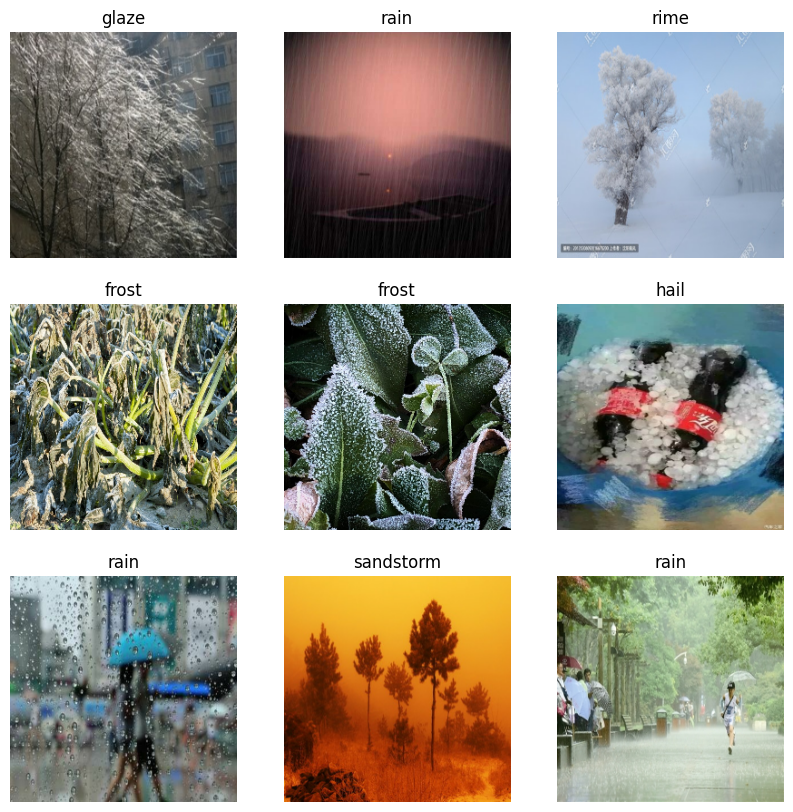

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        label_index = tf.argmax(labels[i]).numpy()
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[label_index])
        plt.axis("off")

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

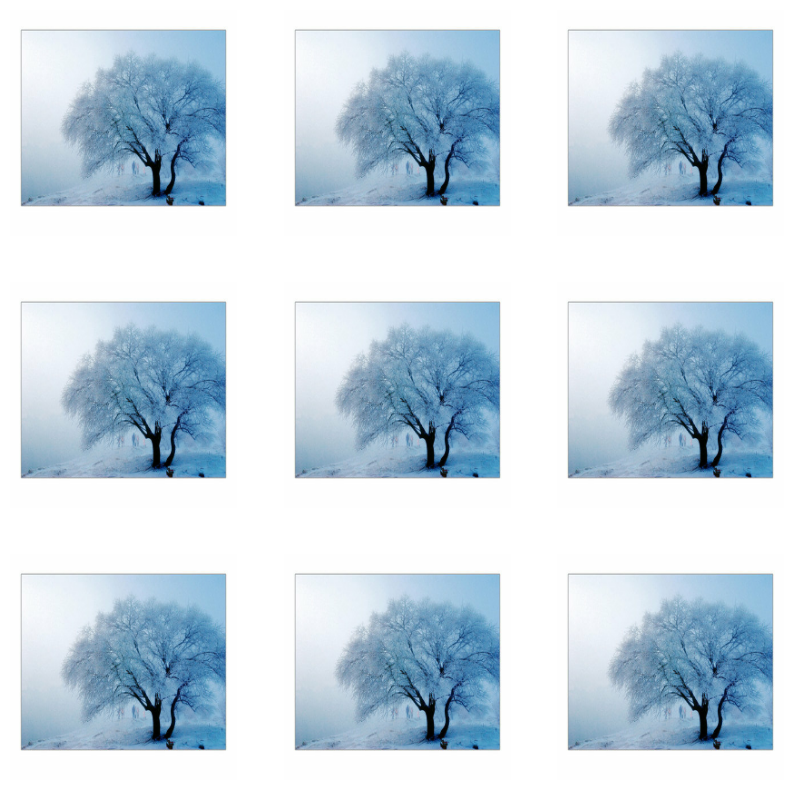

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [37]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [250, 250, 3]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
def model_sequential(num_classes):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(250, 250, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])
    return model

In [14]:
model_seq = model_sequential(11)
model_seq.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )

epochs=10
history_seq = model_seq.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
43/43 [==============================] - 16s 337ms/step - loss: 8.2030 - accuracy: 0.1018 - val_loss: 7.9416 - val_accuracy: 0.1028
Epoch 2/10
43/43 [==============================] - 16s 332ms/step - loss: 8.1530 - accuracy: 0.1015 - val_loss: 7.9416 - val_accuracy: 0.1028
Epoch 3/10
43/43 [==============================] - 16s 336ms/step - loss: 8.1530 - accuracy: 0.1015 - val_loss: 7.9416 - val_accuracy: 0.1028
Epoch 4/10
43/43 [==============================] - 16s 330ms/step - loss: 8.1530 - accuracy: 0.1015 - val_loss: 7.9416 - val_accuracy: 0.1028
Epoch 5/10
43/43 [==============================] - 16s 330ms/step - loss: 8.1530 - accuracy: 0.1015 - val_loss: 7.9416 - val_accuracy: 0.1028
Epoch 6/10
43/43 [==============================] - 16s 330ms/step - loss: 8.1530 - accuracy: 0.1015 - val_loss: 7.9416 - val_accuracy: 0.1028
Epoch 7/10
43/43 [==============================] - 15s 328ms/step - loss: 8.1530 - accuracy: 0.1015 - val_loss: 7.9416 - val_accuracy: 0.1028

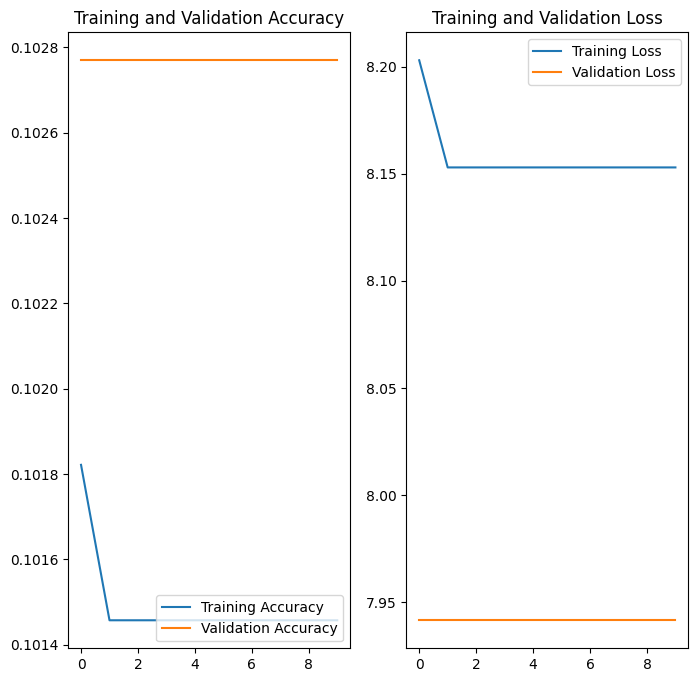

In [15]:
acc = history_seq.history['accuracy']
val_acc = history_seq.history['val_accuracy']

loss = history_seq.history['loss']
val_loss = history_seq.history['val_loss']

epochs_range = range(10)
#range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models\\save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


344/344 [==============================] - 28s 76ms/step - loss: 1.6848 - accuracy: 0.4311 - val_loss: 3.5760 - val_accuracy: 0.2055
Epoch 2/25
344/344 [==============================] - 26s 75ms/step - loss: 1.3649 - accuracy: 0.5257 - val_loss: 1.4787 - val_accuracy: 0.4606
Epoch 3/25
344/344 [==============================] - 26s 74ms/step - loss: 1.3042 - accuracy: 0.5412 - val_loss: 2.2237 - val_accuracy: 0.2996
Epoch 4/25
344/344 [==============================] - 26s 74ms/step - loss: 1.1855 - accuracy: 0.5843 - val_loss: 1.5539 - val_accuracy: 0.5117
Epoch 5/25
344/344 [==============================] - 26s 74ms/step - loss: 1.1360 - accuracy: 0.5974 - val_loss: 1.2024 - val_accuracy: 0.5845
Epoch 6/25
344/344 [==============================] - 26s 74ms/step - loss: 1.0857 - accuracy: 0.6169 - val_loss: 1.2933 - val_accuracy: 0.5816
Epoch 7/25
344/344 [==============================] - 25s 74ms/step - loss: 1.0374 - accuracy: 0.6306 - val_loss: 1.6940 - val_accuracy: 0.4796
Epo

In [10]:
from tensorflow.keras.models import load_model

final_modal = load_model("..\\models\\deep_learning\\keras_models\\save_at_25.keras")

<PIL.Image.Image image mode=RGB size=250x250 at 0x18E8DFE1C08>
1/1 [==============================] - 0s 13ms/step
[[2.4207146e-03 7.6437980e-04 1.1864649e-02 3.5696261e-02 3.4453981e-02
  1.5112458e-06 8.8961709e-01 9.0842361e-05 1.7240134e-04 3.0123815e-03
  2.1905767e-02]]
Clase predicha: rain


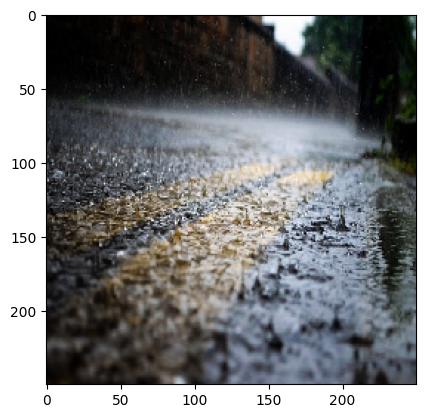

In [19]:
img = keras.utils.load_img(
    "rain_test.jpg", target_size=image_size
)
img = img.resize((250,250))
print(img)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = final_modal.predict(img_array)
predicted_label = np.argmax(predictions)
predicted_label_name = class_names[predicted_label]
print(predictions)
print("Clase predicha:", predicted_label_name)
#print(f"This image is {100 * (1 - score):.2f}% rain and {100 * score:.2f}% rest.")

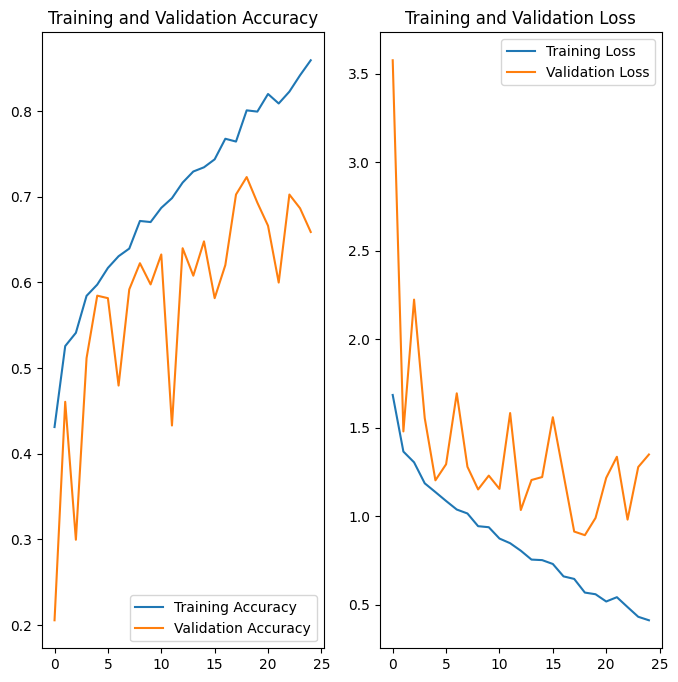

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
image_size = (250, 250)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\raw",
    label_mode='categorical',
    validation_split=0.2,
    subset="both",
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


In [48]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models_2\\save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


172/172 [==============================] - 27s 153ms/step - loss: 1.3577 - accuracy: 0.5251 - val_loss: 4.1119 - val_accuracy: 0.1399
Epoch 2/25
172/172 [==============================] - 26s 151ms/step - loss: 1.2511 - accuracy: 0.5634 - val_loss: 2.9955 - val_accuracy: 0.2063
Epoch 3/25
172/172 [==============================] - 26s 151ms/step - loss: 1.1450 - accuracy: 0.5942 - val_loss: 1.7871 - val_accuracy: 0.4300
Epoch 4/25
172/172 [==============================] - 26s 149ms/step - loss: 1.0652 - accuracy: 0.6246 - val_loss: 1.2716 - val_accuracy: 0.5860
Epoch 5/25
172/172 [==============================] - 26s 150ms/step - loss: 0.9901 - accuracy: 0.6556 - val_loss: 1.5736 - val_accuracy: 0.5328
Epoch 6/25
172/172 [==============================] - 26s 151ms/step - loss: 0.9409 - accuracy: 0.6636 - val_loss: 2.7978 - val_accuracy: 0.1983
Epoch 7/25
172/172 [==============================] - 26s 150ms/step - loss: 0.9064 - accuracy: 0.6816 - val_loss: 1.3506 - val_accuracy: 0.5

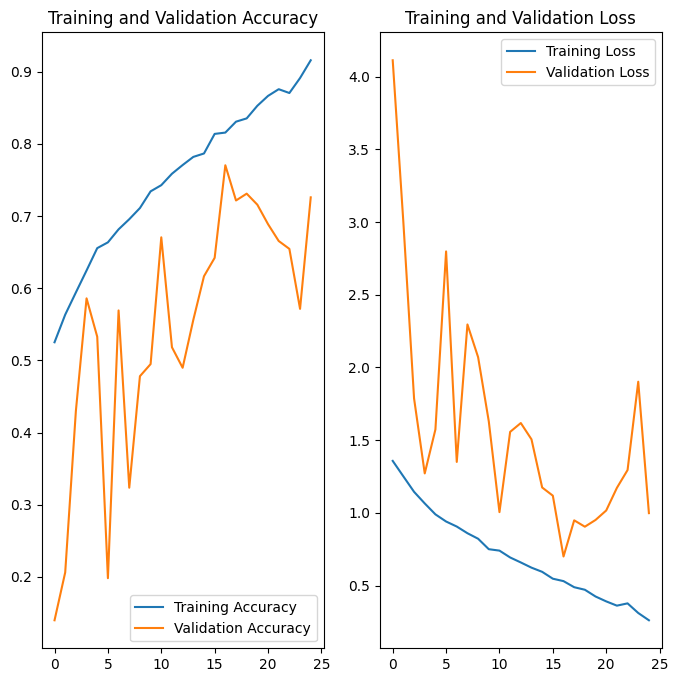

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()